*UE Learning from User-generated Data, CP MMS, JKU Linz 2022*
# Exercise 3: Model-based approaches
In this exercise we'll have a look at two different takes on Matrix Factorization and prepare to learn about ways to evaluate recommender systems.

The assignment submission deadline is 26.04.2022 23:59.

Make sure to rename the notebook according to the convention:\
LUD22_ex03_k<font color='red'>\<Matr. Number\></font>_<font color='red'>\<Surname-Name\></font>.ipynb

for example:

LUD22_ex03_k000007_Bond-James.ipynb

## Implementation
In this exercise, as before, you are reqired to write a number of functions. Insert your implementations into the templates provided. Please don't change the templates even if they are not pretty. Don't forget to test your implementation for correctness and efficiency.

Please **only use libraries already imported in the notebook**. *Feel free to experiment with the notebook, but clean it up before submitting.*

In [1]:
import pandas as pd
import numpy as np
import random as rnd

import torch
from torch import nn, optim
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm


# data reader from previous exercises
def inter_matr_binary(usr_path='sampled_1000_items_demo.txt',
                      itm_path='sampled_1000_items_tracks.txt',
                      inter_path='sampled_1000_items_inter.txt',
                      threshold=1) -> np.ndarray:
    '''
    usr_path - string path to the file with users data;
    itm_path - string path to the file with item data;
    inter_path - string path to the file with interaction data;
    threshold - int > 0, criteria of a valid interaction
    
    returns - 2D np.array, rows - users, columns - items;
    '''

    res = None

    # reading the three data files
    users = pd.read_csv(usr_path, sep='\t', header=None, names=['location', 'age', 'gender', 'date'])
    items = pd.read_csv(itm_path, sep='\t', header=None, names=['artist', 'track'])
    interactions = pd.read_csv(inter_path, sep='\t', header=None, names=['user', 'item', 'num_inters'])

    # getting number of users and items from the respective files to be on the safe side
    n_users = len(users.index)
    n_items = len(items.index)

    # preparing the output matrix
    res = np.zeros([n_users, n_items])

    # for every interaction assign 1 to the respective element of the matrix
    for _, inter in interactions.iterrows():
        curr_user = inter['user']
        curr_item = inter['item']
        res[curr_user, curr_item] = 1 if inter['num_inters'] >= threshold else 0

    return res

## Matrix Factorization
In the previous exercise we implented ItemKNN which is a Memory-based approach. It means that in order for the model to function we have to keep all known to us interactions (the full interaction matrix) in the memory, this can be cumbersome.
    
The idea of Model-based approaches is to learn some kind of compact representation of the matrix. Most common scenario is the following: instead of representing every user through all the items and every item through all the users (full interaction matrix) let's represent both in a latent vector space of some smaller dimensionality **f**.

It means that instead of the one full interaction matrix **inter**: (**users** x **items**) we'll need to keep in memory two much smaller matrices: one with user-representations **U**: (**users** x **f**), one with item representations **V**: (**items** x **f**). And we'll learn those two in such a way that we can recreate the information contained in the full interaction matrix, for example through dot product:
    
inter[**user**, **item**] = U[**user**, :] @ V[**item**, :].T
    
Such approach is generally called Matrix Factorization, because we split one huge unbearable matrix into multiple smaller bearable ones. It has the following benefits:
* The two new matrices combined (should) take less space than the full interaction matrix and thus easier fit into memory;
* Selecting a reasonable **f** means that we operate with shorter vectors during all kinds of calculations, this decreases computational load during recommendation making online inference easier;
* Matrix factorization compresses sparce information contained in the interaction matrix into an elegant representation and can potentially encode **hidden dependencies**;
* Having both items and users represented in the the same **f**-dimensional space opens new possibilities for recommendation;
    
Now let's have a look at how we can actually perform this trick.
    
### Singular Value Decomposition (SVD)
As it often happens, linear algebra has answers. And Singular Vector Decomposition is one.

A $n * m$ matrix $I$ can be decomposed into a product of 3 matrices:<br>
$I = U\Sigma V^T$

$U$ -- orthogonal ($n * n$) matrix composed of left singular vectors (it corresponds to users);<br>
$\Sigma$ -- ($n * m$) diagonal matrix, containing singular values;<br>
$V$ -- orthogonal ($m * m$) matrix composed of right singular vectors (it corresponds to items);<br>

#### <font color='#666666'>Thin Variant</font> of  Singular Vector Decomposition
As before:<br>
$I = U\Sigma V^T$

We can exploit the fact that $I$ (usually) is not square and cannot have *full rank*.<br>
$k = min(n, m)$

As a result $U$, $\Sigma$ and $V$ have different dimensions:<br>
$U$ -- ($n *$ <font color='red'>$k$</font>) of left singular vectors (it corresponds to users);<br>
$\Sigma$ -- (<font color='red'>$k$</font> $*$ <font color='red'>$k$</font>) square diagonal matrix, containing singular values;<br>
$V$ -- ($m *$ <font color='red'>$k$</font>) of right singular vectors (it corresponds to items);<br>

In [2]:
# consider an interaction matrix with 4 users and 5 items
inter_matr = np.array(
    [
        [0, 1, 1, 1, 0],
        [1, 0, 1, 1, 0],
        [0, 1, 0, 0, 1],
        [1, 0, 0, 1, 1]
    ]
)
# let's now apply Thin (k==4) SVD to it, we'll get the following: 

# U - (4, 4) matrix, corresponding to users
# s - (4) singular values - each element shows how informative the corresponding dimension is
# Vh - (4, 5) already transposed matrix corresponding to items

# we set 'full_matrices' to 'False' for Thin SVD
U, s, Vh = np.linalg.svd(inter_matr, full_matrices=False)

# let's quickly construct the matrix back to make sure everything works
res = (U @ np.diag(s)) @ Vh

print('users\' representations:\n', U, '\n')
print('items\' representations:\n', Vh.T, '\n')  # Transposing to have first dimension correspond to items
print('singular values:', s, '\n')
print('reconstructed matrix\n', res, '\n')
print('reconstructed matrix (rounded)\n', res.round())

users' representations:
 [[ 5.42463675e-01 -9.81751217e-02  7.07106781e-01 -4.42825933e-01]
 [ 5.97192605e-01  5.10969410e-01  1.60982339e-15  6.18280887e-01]
 [ 2.34152336e-01 -8.48312179e-01 -2.38697950e-15  4.74909602e-01]
 [ 5.42463675e-01 -9.81751217e-02 -7.07106781e-01 -4.42825933e-01]] 

items' representations:
 [[ 4.42491536e-01  2.76337063e-01 -5.00000000e-01  4.77324909e-01]
 [ 3.01534785e-01 -6.33607412e-01  5.00000000e-01  8.72835678e-02]
 [ 4.42491536e-01  2.76337063e-01  5.00000000e-01  4.77324909e-01]
 [ 6.53112570e-01  2.10615648e-01  7.00828284e-16 -7.27382307e-01]
 [ 3.01534785e-01 -6.33607412e-01 -5.00000000e-01  8.72835678e-02]] 

singular values: [2.57554368 1.49380718 1.41421356 0.36757971] 

reconstructed matrix
 [[ 2.18105159e-16  1.00000000e+00  1.00000000e+00  1.00000000e+00
   2.90442620e-16]
 [ 1.00000000e+00  4.30508487e-16  1.00000000e+00  1.00000000e+00
   3.31469520e-16]
 [ 3.39422927e-16  1.00000000e+00  6.14107010e-16  1.51460008e-16
   1.00000000e+00]

#### Cool things about SVD
SVD projects all the variance contained in the data onto orthogonal basis of $k$ vectors.<br>
Singular values ($\Sigma$ or $s$) allow us to judge how much variance is "situated" along each vector. It is also acts as weighting for the $k$ dimensions;

| $\Sigma$ |  |  |  |
|--|--|--|--|
| **2.58** | 0.0 | 0.0 | 0.0 |
| 0.0 | **1.49** | 0.0  | 0.0 |
| 0.0 | 0.0 | **1.41** | 0.0 |
| 0.0 | 0.0 | 0.0 | **0.37** |

Basing on that, we can choose $f < k$ (remember $f$?⬆) dimensions to represent the whole data. Choosing dimensions corresponding to lagest singular values we make sure to keep most of the information contained in the full interaction matrix while decreasing its size and maybe even filtering some noise out. $U$ and $V^T$ become ($n *$ <font color='red'>$f$</font>) and (<font color='red'>$f$</font> $* m$) respectively.<br><br>
Let's select only $f = 2$ or $3$ **first** latent features out of $4$ we got, and check how the matrix will change. This is called **truncated SVD**.

**Note!** We take first $f$ latent features, because they correspond to higher variance (usually SVD implementations arrange the dimensions in the order of decreasing variance). Higer variance means more *signal* captured with the corresponding dimension. 

In [3]:
print('reconstructed interaction matrix with f = 4, no truncation:\n', res.round())

# Taking 3 most informative dimensions
f = 3
res_trunc_3 = (U[:, :f] @ np.diag(s[:f])) @ Vh[:f, :]
print('reconstructed interaction matrix with f = ', f, ', truncated:\n', res_trunc_3.round())

# Taking only 2 most informative dimensions
f = 2
res_trunc_2 = (U[:, :f] @ np.diag(s[:f])) @ Vh[:f, :]
print('reconstructed interaction matrix with f = ', f, ', truncated:\n', res_trunc_2.round())

reconstructed interaction matrix with f = 4, no truncation:
 [[ 0.  1.  1.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1. -0.  0.  1.  1.]]
reconstructed interaction matrix with f =  3 , truncated:
 [[ 0.  1.  1.  1.  0.]
 [ 1. -0.  1.  1. -0.]
 [-0.  1. -0.  0.  1.]
 [ 1.  0.  0.  1.  1.]]
reconstructed interaction matrix with f =  2 , truncated:
 [[ 1.  1.  1.  1.  1.]
 [ 1. -0.  1.  1. -0.]
 [-0.  1. -0.  0.  1.]
 [ 1.  1.  1.  1.  1.]]


You can notice that selecting 3 most informative features gives a result very similar to the full set of features. This is no wonder, the 4th dimension corresponds to the lowest variance of 0.37, see the table above.

Selecting 2 most informative features gives visible difference in the result even within our toy example.

#### Final representations
Our goal with matrix factorization is to have two matrices: one for users and the other for items. Right now we have an array of weights (singular values) in addition to this. For the sake of convenience let's just merge those weights into the two matrices (see lecture slides):

In [4]:
U_final = U @ np.diag(s ** 0.5)  # users x features
V_final = (np.diag(s ** 0.5) @ Vh).T  # items x features

print('Interaction Matrix reconstructed through U, V and s:\n', ((U @ np.diag(s)) @ Vh).round(), '\n')
print('Interaction Matrix reconstructed through U_final and V_final:\n', (U_final @ V_final.T).round(), '\n')
print('Original Interaction Matrix:\n', inter_matr)

Interaction Matrix reconstructed through U, V and s:
 [[ 0.  1.  1.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1. -0.  0.  1.  1.]] 

Interaction Matrix reconstructed through U_final and V_final:
 [[ 0.  1.  1.  1.  0.]
 [ 1.  0.  1.  1.  0.]
 [ 0.  1.  0.  0.  1.]
 [ 1. -0.  0.  1.  1.]] 

Original Interaction Matrix:
 [[0 1 1 1 0]
 [1 0 1 1 0]
 [0 1 0 0 1]
 [1 0 0 1 1]]


Now in the two final matrices of representations U_final and V_final we essentially have user- and item-embeddings stored. All what is left is to truncate them to our liking (select $f$ first dimensions) and proceed to recommendation.

Reasons to truncate:
* Save space in memory
* Dimensions with lower corresponding variance are likely to contain noise. Truncating the representations we concentrate on the strongest patterns

#### Recommendation with Matrix Factorization
With the two sets of embeddings U_final and V_final there is a multitude of ways to recommend items to users.
In this exercise we take advantage of the fact that we represent both users and items in the same f-dimensional vector space. It means that we can estimate similarity directly between users and items, using, for example, cosine similarity.

So to recommend items for a user with id **u** we would create a list of all items ranked according to the cosine similarity between the user vector U_final[**u**,:] and corresponding item-vectors from V_final (V_final[**i**, :], make sure to take the correct orientation of the matrix). Then as before we should remove items already seen by the user and take Top K (how ever many recommendations we need) of the resulting list.

## <font color='red'>TASK 1/3</font>: Matrix Factorization with SVD
Complete the templates below to create an MF-SVD recommender.\
The first function should return two sets of embeddings (for users and for items) of given length (Truncated SVD!).

Make sure to put the data files: *sampled_1000_items_inter.txt*, *sampled_1000_items_demo.txt* and *sampled_1000_items_tracks.txt* next to the notebook.

In [5]:
def svd_decompose(inter_matr: np.ndarray, f=50) -> (np.ndarray, np.ndarray):
    """
    inter_matr - np.ndarray - interaction matrix to construct svd from.
    f - int - expected size of embeddings
    
    returns - U_final, V_final - (as above) user-/item-embeddings of given length f
    """

    U_final = None
    V_final = None

    # TODO: YOUR IMPLEMENATION.
    U, s, Vh = np.linalg.svd(inter_matr, full_matrices=False)

    U_final = U[:, :f] @ np.diag(s[:f] ** 0.5)  # users x features
    V_final = (np.diag(s[:f] ** 0.5) @ Vh[:f, :]).T  # items x features

    return U_final, V_final

In [6]:
train_data_inter = inter_matr_binary(usr_path='sampled_1000_items_demo.txt',
                                     itm_path='sampled_1000_items_tracks.txt',
                                     inter_path='sampled_1000_items_inter.txt')

U, V = svd_decompose(train_data_inter, 60)

assert U is not None and V is not None, "The variables should not be None."
assert U.shape == (1194, 60), "U has incorrect shape"
assert V.shape == (412, 60), "V has incorrect shape"

The function below is meant for Batch recommendation. Given a list of User ids, a list of arrays with item ids consumed by the respective users, U_final, V_final and expected number of recommendations, the function returns a list of recommendation arrays for every user. The order of users should correspond to the order in the input list, the items, as before, should be ordered from most to least recommended.

In [7]:
def svd_recommend_to_list(user_ids: list, seen_item_ids: list, U: np.ndarray, V: np.ndarray, topK: int) -> np.ndarray:
    """
    Recommend with svd to selected users
    
    user_ids - list[int] - ids of target users.
    seen_item_ids - list[list[int]] ids of items already seen by the users (to exclude from recommendation)
    U and V - user- and item-embeddings
    topK - number of recommendations per user to be returned
    
    returns - np.ndarray - list of lists of ids of recommended items in the order of descending score, for every user
                           make sure the dimensions are correct: [(number of user_ids) x (topK)]
                           use -1 as a place holder item index, when it is impossible to recommend topK items
    """
    recs = None

    # TODO: YOUR IMPLEMENTATION.

    if topK > 412:
        raise ValueError

    recs = np.full(shape=(len(user_ids), topK), fill_value=-1)

    my_matrix = cosine_similarity(U[user_ids, :], V)
    for i, user in enumerate(user_ids):
        my_matrix[i, seen_item_ids[i]] = -np.inf

        score_ind = np.argsort(my_matrix[i])
        # indices, sorted in the order of descending popularity

        recs[i] = score_ind[-topK:][::-1]

        ##Didn't optimize and test yet, might not work optimally
        maxvalue = (topK + len(seen_item_ids[i])) - 411
        if maxvalue > 0:
            for k in range(maxvalue):
                recs[i, -k] = -1

    return np.asarray(recs)

## <font color='red'>TASK 2/3</font>: Iterative Matrix Factorization with PyTorch

In the first task we utilized a deterministic method (SVD) to obtain user- and item-embeddings. It means that an equation needs to be solved every time we do so, and the whole process (for the whole matrix) needs to be repeated every time a new item or a new user are added to the system. Notice also that with SVD we are doing some extra work by first getting the embbeddings of length k and then truncating them to our desired length.

Iterative approach to MF allows us to train embeddings of the desired length straight away, gives more flexibility in setting the training objective and updating the parameters/adding new users (e.g. through 'fine tuning').

Your task is to implemet matrix factorization using PyTorch, please follow the specifciactions closely and referer to the provided introduction to PyTorch (separate notebook). Use Moodle forum if you have any questions.

First, you need to construct a module consisting of two layers (those will be our **U_final** and **V_final** that we are after):

1) An Embedding Layer from User space to Latent space  (user id -> f-dim vector)<br>
2) An Embedding Layer from Item space to Latent space (item id -> f-dim vector)<br>

Use the <b>nn.Embedding</b> Module. Implement the forward function: as with SVD we'll set the training objective to reconstruct the interaction matrix. So multiplying U and V (with transposition applied correctly) we should get an approximation of the interaction matrix. 

In [8]:
class MF(nn.Module):

    def __init__(self, n_users: int, n_items: int, n_factors: int):
        """
        n_users - int - number of users.
        n_items - int - number of items.
        n_factors - int - dimensionality of the latent space.
        """

        super(MF, self).__init__()

        self.embedding_user = None
        self.embedding_item = None

        # TODO: YOUR IMPLEMENTATION.

        self.embedding_user = nn.Embedding(n_users, n_factors)
        self.embedding_item = nn.Embedding(n_items, n_factors)

        # to initialize the weight of some layer with a constant value.
        #nn.init.constant_(self.embedding_user.weight, 0.8)
        #nn.init.constant_(self.embedding_item.weight, 0.3)

    def forward(self, user: torch.Tensor, item: torch.Tensor) -> torch.Tensor:
        """
        We allow for some flexibility giving lists of ids as inputs:
        if the training data is small we can deal with it in a single forward pass,
        otherwise we could fall back to mini-batches, limiting users and items we pass
        every time.

        user - torch.Tensor - user_ids.
        item - torch.Tensor - item_ids.

        returns - torch.Tensor - Reconstructed Interaction matrix of shape (n_users, n_items).
        """
        res = None

        # TODO: YOUR IMPLEMENTATION.
        user = self.embedding_user(user)
        item = self.embedding_item(item)

        return torch.matmul(user, item.T)


We have a model with the two embedding sets, and it is able to reconstruct the interaction matrix through them.

Next we need a way to evaluate the reconstruction effort, this is what loss function helps us with.
For our case we will use the Binary Cross Entropy Loss, please implement the compute_loss function and use nn.BCELoss to calculate the loss.

<b>Tip:</b> Make sure to first project the logits to the [0, 1] interval using sigmoid activation.

In [9]:
def compute_loss(logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    """
    logits - torch.Tensor - output of model.
    labels - torch.Tensor - labels / interaction matrix model should learn to reconstruct.

    returns - torch.Tensor - BCELoss over all logits and labels.
    """
    loss = None

    # TODO: YOUR IMPLEMENTATION.
    logits = torch.sigmoid(logits)

    loss = nn.BCELoss()
    return loss(logits, labels)

Implement the train function and return the loss over all epochs.
For simplicity we pass the full interaction matrix (all user and item ids) at once.

In [10]:
def train(model: nn.Module, train_data_inter: np.ndarray, epochs: int, optimizer, loss_func) -> list:
    """
    model - nn.Module - torch module to train.
    train_data_inter - np.ndarray - interaction matrix of the training data.
    epochs - int - number of epochs to perform.
    optimizer - optim - optimizer for training.
    loss_func - loss function for training.
    
    returns - list - list of loss values over all epochs.
    """
    losses = []

    model.train()
    # TODO: YOUR IMPLEMENTAION.

    user_ids = torch.IntTensor(list(range(train_data_inter.shape[0])))
    item_ids = torch.IntTensor(list(range(train_data_inter.shape[1])))

    train_data_inter = torch.Tensor(train_data_inter)
    for _ in range(epochs):

        optimizer.zero_grad()
        prediction = model(user_ids, item_ids)
        loss = loss_func(prediction, train_data_inter)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if _ % 10 == 0:
            print(loss.item())
    return losses

### Training a model with the following parameters

<b>Learning rate:</b> 0.001<br>
<b>Optimizer:</b> Adam<br>
<b>Factor size:</b> 128<br>

Of course, we encourage you to try out multiple different paremeters, just for you to get a feeling of this model, but for this exercise we fixed the parameters for you.

In [11]:
# Do not change the seed.
torch.manual_seed(1234)
rnd.seed(1234)
np.random.seed(1234)

model_128 = None
optimizer = None

# TODO: YOUR IMPLEMENATION.
# Initialize the model and optimizer as prescribed
#1194 users, 412 songs
model_128 = MF(1194, 412, n_factors=128)

optimizer = optim.Adam(model_128.parameters(), lr=0.001)


In [12]:
assert model_128 is not None and optimizer is not None, "Model and optimizer should be initilized."
assert type(optimizer) == optim.Adam

assert model_128.embedding_user is not None and model_128.embedding_item is not None, "Embedding Layers need to be not None."
assert type(model_128.embedding_user) == nn.Embedding, "Embedding Layer should be of type nn.Embedding."
assert type(model_128.embedding_item) == nn.Embedding, "Embedding Layer should be of type nn.Embedding."

assert model_128.embedding_item.embedding_dim == 128, "Item Embedding Layer wrong embedding size."
assert model_128.embedding_user.embedding_dim == 128, "User Embedding Layer wromg embedding size."

#### Training model

Lets train the model for <b>1000</b> epochs and look at the returned loss.

In [13]:
loss_model_128 = train(model=model_128,
                       train_data_inter=train_data_inter,
                       epochs=1000,
                       optimizer=optimizer,
                       loss_func=compute_loss)

assert len(loss_model_128) == 1000, "Loss should have 1000 elements, one for each epoch."

9.99675464630127
9.740233421325684
9.49190902709961
9.242265701293945
8.9867582321167
8.740788459777832
8.48522663116455
8.217864990234375
7.948935031890869
7.657566070556641
7.372904300689697
7.056423187255859
6.728239059448242
6.395613670349121
6.0357489585876465
5.64617395401001
5.258042812347412
4.865944862365723
4.476346969604492
4.09126615524292
3.7147958278656006
3.3527164459228516
3.003810167312622
2.6759297847747803
2.379127025604248
2.122225761413574
1.8778239488601685
1.6669727563858032
1.4816986322402954
1.3161985874176025
1.17442786693573
1.055530309677124
0.9546449184417725
0.862669050693512
0.7839226722717285
0.7139539122581482
0.652629554271698
0.6042264699935913
0.5617193579673767
0.5234028100967407
0.4913998544216156
0.46379512548446655
0.4393714368343353
0.41683274507522583
0.3945385217666626
0.37724289298057556
0.3611605763435364
0.34647074341773987
0.3333786725997925
0.3214273154735565
0.31103450059890747
0.3007390797138214
0.2916604280471802
0.2835707664489746
0.2

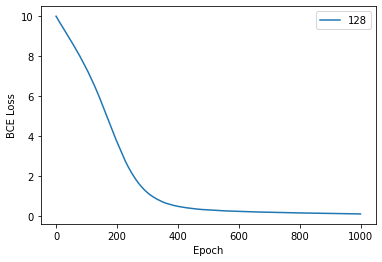

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss_model_128, label="128")

plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

#### Recommendations with the trained Factorization Model
Write a function that recommends topK items to each of the users, whose ids are given, using the trained model.
Recommendation should be done in a fashion similar to *svd_recommend_to_list*: for each user score items based on cosine similarity of the corresponding embeddings. Do not consider items already seen by the user.

In [15]:
def itMF_recommend_to_list(user_ids: list, seen_item_ids: list, model=model_128, topK=10) -> np.ndarray:
    """
    Recommend with the trained model to selected users
    
    user_ids - list[int] - ids of target users.
    seen_item_ids - list[list[int]] ids of items already seen by the users (to exclude from recommendation)
    model - trained factorization model to use for scoring
    topK - number of recommendations per user to be returned
    
    returns - np.ndarray - list of lists of ids of recommended items in the order of descending score, for every user
                           make sure the dimensions are correct: [(number of user_ids) x (topK)]
                           use -1 as a place holder item index, when it is impossible to recommend topK items
    """
    recs = None

    # TODO: YOUR IMPLEMENTATION.

    if topK > 412:
        raise ValueError

    recs = np.full(shape=(len(user_ids), topK), fill_value=-1)

    item_ids = torch.IntTensor(list(range(412)))

    U = model_128.embedding_user(torch.IntTensor(user_ids)).detach().numpy()
    V = model_128.embedding_item(item_ids).detach().numpy()

    my_matrix = cosine_similarity(U, V)

    for i, user in enumerate(user_ids):
        my_matrix[i, seen_item_ids[i]] = -np.inf

        score_ind = np.argsort(my_matrix[i])
        recs[i] = score_ind[-topK:][::-1]

    return np.asarray(recs)


In [16]:
#inter_act_matr = inter_matr_binary()
#users_list = [0, 1, 2, 3, 4, 5, 6]
#seen_list = [np.where(inter_act_matr[user] != 0)[0] for user in users_list]

#recs = svd_recommend_to_list(users_list, seen_list, U, V, 10)
#print(recs)

#recs = itMF_recommend_to_list(users_list, seen_list, MF)
#print(recs)

## <font color='red'>TASK 3/3</font>: Data Split
In order to minimize influence of random chance during evaluation it is good to conduct it on multiple different Data Splits.
In this task you are required to write a function that randomly splits all the interactions into TEST and TRAIN files in given proportion (0.2 by default, meaning 20% of interactions should become the TEST set).

It should receive a name of a file, containing interaction data in LFM2B format (as in the previous exercise) as input.The function is expected to randomly split the records from the file, approximately in given proportion into Train and Test sets (proportion of 0.2 means that the number of Test records to the number of Train records should be 20:80).The function needs to save the result into two separate files in LFM2B format, one for Test interactions, one for Train interactions.

In [17]:
def split_interactions(inter_file='sampled_1000_items_inter.txt',
                       proportion=0.2,
                       res_test_file='sampled_1000_items_inter_TEST.txt',
                       res_train_file='sampled_1000_items_inter_TRAIN.txt'):
    '''
    inter_file - string - path to the file with interaction data in LFM2B format;
    proportion - float - proportion of records from inter_file to become the Test Set;
    res_test_file - string - Test records will be saved here;
    res_train_file - string - Train records will be saved here;
    
    returns - nothing, but saves the two files in LF2B format;
    '''

    interactions = pd.read_csv(inter_file, sep='\t', header=None, names=['user', 'item', 'num_inters'])

    train = None
    test = None

    # TODO: YOUR IMPLEMENTATION.
    interactions = interactions.sample(frac=1).reset_index(drop=True)
    split = int(interactions.shape[0] * (1 - proportion))
    train = interactions[:split]
    test= interactions[split:]

    # saving the res files
    # train and test - pd.DataFrames
    train.to_csv(res_train_file, index=False, header=False, sep='\t')
    test.to_csv(res_test_file, index=False, header=False, sep='\t')

In [18]:
split_interactions(inter_file='sampled_1000_items_inter.txt',
                   proportion=0.2,
                   res_test_file='sampled_1000_items_inter_TEST.txt',
                   res_train_file='sampled_1000_items_inter_TRAIN.txt')

In [19]:
# Load the train and test interactions, you just split up.

train_data_inter = None
test_data_inter = None

train_data_inter = inter_matr_binary(usr_path='sampled_1000_items_demo.txt',
                                     itm_path='sampled_1000_items_tracks.txt',
                                     inter_path='sampled_1000_items_inter_TRAIN.txt')
test_data_inter = inter_matr_binary(usr_path='sampled_1000_items_demo.txt',
                                    itm_path='sampled_1000_items_tracks.txt',
                                    inter_path='sampled_1000_items_inter_TEST.txt')

In [20]:
test_len = len(test_data_inter[test_data_inter == 1])
train_len = len(train_data_inter[train_data_inter == 1])
prop = test_len / (train_len + test_len)
# very rough evaluation
assert prop < 0.3, "Test set is too big."
assert prop > 0.1, "Test set is too small."

In [21]:
# The end.